<a href="https://colab.research.google.com/github/ysleead/comp4211_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# comp4211 project

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# New Section

In [0]:
import os
import torch
import PIL
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import transforms, utils, models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import sparse

In [0]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomResizedCrop(size = 512, scale = (0.5,1.0)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class imgDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform):
        df = pd.read_csv(csv_file)
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir+'/'+str(self.df.iloc[idx,0])+'.jpg'
        X = self.transform(PIL.Image.open(img_name).convert('RGB'))
        y = torch.tensor(self.df.iloc[idx,1:])
        return X, y

In [0]:
#file path from my drive
train_data = imgDataset(csv_file = '/content/drive/My Drive/colab/COMP4211 Project/train.csv', 
                       root_dir = "/content/drive/My Drive/colab/COMP4211 Project/images/", transform = transform)

train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size

train, valid = random_split(train_data, [train_size, valid_size])

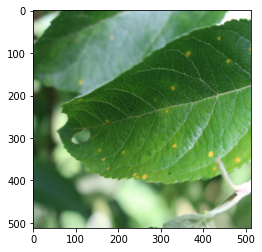

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

imshow(train[0][0])

In [0]:
batch_size = 8

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=4)
valid_loader = DataLoader(valid, batch_size=batch_size,
                          shuffle=True, num_workers=4)

In [0]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(save_path, model, optimizer):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [0]:
def train_model(model, criterion, optimizer, num_epochs, eval_every, device, save_name):
  global_step = 0
  total_step = len(train_loader) * num_epochs
  running_loss = 0.0
  train_losses = []
  val_losses = []
  best_val_loss = float("Inf")

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-------------------")

    for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward
      outputs = model(inputs)
      loss = criterion(outputs, labels.float())
      #backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      global_step += 1
      running_loss += loss.item()

      if global_step % eval_every == 0:
        with torch.no_grad():
          model.eval()
          val_running_loss = 0.0
          for j, (val_inputs, val_labels) in enumerate(valid_loader):
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.float())
            val_running_loss += val_loss.item()

          avg_train_loss = running_loss / eval_every
          avg_val_loss = val_running_loss / len(valid_loader)

          train_losses.append(avg_train_loss)
          val_losses.append(avg_val_loss)

          print(f"Step: {global_step}/{total_step}, Avg train loss: {avg_train_loss:.4f}, Avg val loss: {avg_val_loss:.4f}")
          running_loss = 0.0

          if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
  print("Finished training")
  return train_losses, val_losses
          

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_filters = model.fc.in_features
model.fc = nn.Linear(num_filters, 4)

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [11]:
train_losses, val_losses = train_model(model, criterion, optimizer, 10, 10, device, f'/content/drive/My Drive/colab/COMP4211 Project/resnet.pt')

Epoch 1/10
-------------------
Step: 10/910, Avg train loss: 0.7245, Avg val loss: 0.6590
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/resnet.pt
Step: 20/910, Avg train loss: 0.4560, Avg val loss: 0.2866
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/resnet.pt
Step: 30/910, Avg train loss: 0.2487, Avg val loss: 0.1934
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/resnet.pt
Step: 40/910, Avg train loss: 0.2301, Avg val loss: 0.1795
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/resnet.pt
Step: 50/910, Avg train loss: 0.1792, Avg val loss: 0.1395
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/resnet.pt
Step: 60/910, Avg train loss: 0.2586, Avg val loss: 0.1547
Step: 70/910, Avg train loss: 0.1796, Avg val loss: 0.1420
Step: 80/910, Avg train loss: 0.1768, Avg val loss: 0.1290
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/resnet.pt
Step: 90/910, Avg train loss: 0.0836, Avg

In [0]:

from itertools import cycle
from numpy import interp
from sklearn.metrics import classification_report, plot_confusion_matrix

def eval(model, test_loader, train_losses, val_losses):
  y_pred = np.empty((0,4))
  y_label = np.empty((0,4))
  with torch.no_grad():
    for inputs, labels in test_loader:
      model.eval()
      inputs = inputs.to(device)
      outputs = model(inputs)
      y_pred = np.vstack((y_pred, nn.functional.softmax(outputs, dim=1).cpu().numpy()))
      y_label = np.vstack((y_label, labels.cpu().numpy()))
  print(roc_auc_score(y_label, y_pred, average='macro'))

  n_classes = 4
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(4):
      fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  X1 = np.linspace(0, 100, len(train_losses))
  X2 = np.linspace(0, 100, len(val_losses))
  Y1 = train_losses
  Y2 = val_losses

  plt.figure(num=10, figsize=(14, 4))

  plt.plot(X1, Y1, label='training losses')
  plt.plot(X2, Y2, label='validation losses')
  plt.show()

  # plt.figure()
  lw = 2
  # plt.plot(fpr[2], tpr[2], color='darkorange',
  #         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
  # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

  

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
load_checkpoint(f'/content/drive/My Drive/colab/COMP4211 Project/resnet.pt', model, optimizer)

0.9663424711120455


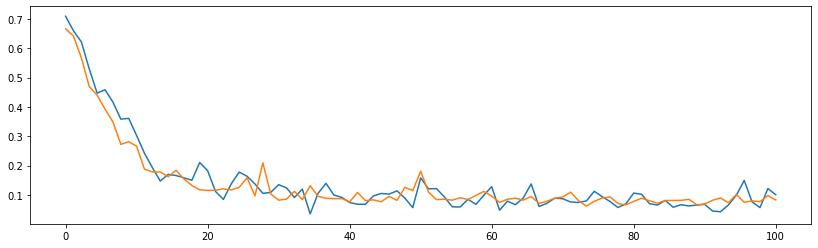

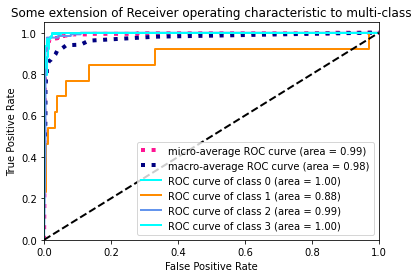

In [46]:
eval(model, valid_loader, train_losses, val_losses)

In [0]:
class Modified_RESNET(nn.Module):

    def __init__(self):
        super(Modified_RESNET, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
          param.requires_grad = False
        num_filters = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_filters, 320)

        self.fc1 = nn.Linear(320, 120)
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40, 4)
        self.bn1 = nn.BatchNorm1d(320)
        self.bn2 = nn.BatchNorm1d(120)
        self.bn3 = nn.BatchNorm1d(40)
        self.drops = nn.Dropout(0.3)

    def forward(self, images):
        x = F.relu(self.resnet(images))
        x = self.drops(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.fc2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modified_resnet = Modified_RESNET()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(modified_resnet.parameters(), lr=5e-5)

modified_resnet = modified_resnet.to(device)
summary(modified_resnet, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [16]:
# training modified resnet
train_losses, val_losses = train_model(modified_resnet, criterion, optimizer, 10, 10, device, f'/content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt')

Epoch 1/10
-------------------
Step: 10/910, Avg train loss: 0.7092, Avg val loss: 0.6663
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
Step: 20/910, Avg train loss: 0.6593, Avg val loss: 0.6417
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
Step: 30/910, Avg train loss: 0.6217, Avg val loss: 0.5670
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
Step: 40/910, Avg train loss: 0.5296, Avg val loss: 0.4694
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
Step: 50/910, Avg train loss: 0.4470, Avg val loss: 0.4399
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
Step: 60/910, Avg train loss: 0.4585, Avg val loss: 0.3924
Model saved to ==> /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
Step: 70/910, Avg train loss: 0.4164, Avg val loss: 0.3489
Model saved to ==> /content/drive/My Drive/col

Model loaded from <== /content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt
0.9559747821428775


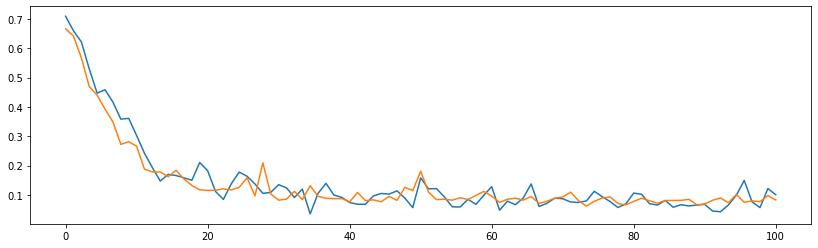

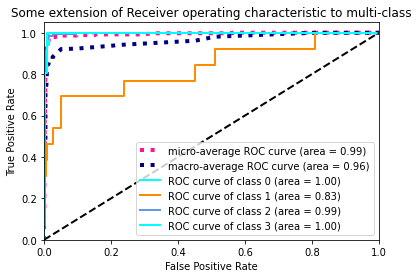

In [47]:
optimizer = torch.optim.Adam(modified_resnet.parameters(), lr=5e-5)
load_checkpoint(f'/content/drive/My Drive/colab/COMP4211 Project/modified_resnet.pt', modified_resnet, optimizer)
eval(modified_resnet, valid_loader, train_losses, val_losses)

In [0]:
# class Modified_VGG(nn.Module):

#     def __init__(self):
#         super(Modified_VGG, self).__init__()
#         self.vgg = models.vgg16(pretrained=True)
#         num_filters = self.vgg.classifier[-1].in_features
#         self.vgg.classifier[-1] = nn.Linear(num_filters, 320)

#         self.fc1 = nn.Linear(320, 120)
#         self.fc2 = nn.Linear(120, 40)
#         self.fc3 = nn.Linear(40, 4)
#         self.bn1 = nn.BatchNorm1d(320)
#         self.bn2 = nn.BatchNorm1d(120)
#         self.bn3 = nn.BatchNorm1d(40)
#         self.drops = nn.Dropout(0.3)

#     def forward(self, images):
#         x = F.relu(self.vgg(images))
#         x = self.drops(x)
#         x = self.bn1(x)
#         x = F.relu(self.fc1(x))
#         x = self.drops(x)
#         x = self.bn2(x)
#         x = F.relu(self.fc2(x))
#         x = self.drops(x)
#         x = self.bn3(x)
#         x = self.fc3(x)
#         return x

In [23]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# modified_vgg= Modified_VGG()

# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(modified_vgg.parameters(), lr=5e-5)

# modified_vgg = modified_vgg.to(device)
# summary(modified_vgg, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [0]:
# training modified vgg

# #####not using#####
# train_losses, val_losses = train_model(modified_vgg, criterion, optimizer, 10, 50, device, f'modified_vgg.pt')

In [0]:
# load_checkpoint(f'/content/drive/My Drive/colab/COMP4211 Project/modified_vgg.pt', modified_resnet, optimizer)
# eval(modified_vgg, valid_loader, train_losses, val_losses)

In [10]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=bd35005e1febd89859c4e9e033c0d181432cd60e5c29273a248807ff3461785f
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [1]:
from efficientnet_pytorch import EfficientNet
class Modified_Efficient_Net(nn.Module):

    def __init__(self):
        super(Modified_Efficient_Net, self).__init__()
        self.ef = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4)

    def forward(self, images):
        x = self.ef(images)
        return x

NameError: ignored

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

efficient_net= Modified_Efficient_Net()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_net.parameters(), lr=5e-5)

efficient_net = efficient_net.to(device)
summary(efficient_net, (3, 512, 512))

Loaded pretrained weights for efficientnet-b7


RuntimeError: ignored

In [18]:
train_losses, val_losses = train_model(efficient_net, criterion, optimizer, 10, 10, device, f'/content/drive/My Drive/colab/COMP4211 Project/efficient_net.pt')

Epoch 1/10
-------------------


RuntimeError: ignored

In [0]:
load_checkpoint(f'/content/drive/My Drive/colab/COMP4211 Project/efficient_net.pt', efficient_net, optimizer)
eval(efficient_net, valid_loader, train_losses, val_losses)